## Numbers Dataset

We have a dataset of handwritten digits from 0 to 9

We need some library to read the images, I've chosen the pillow library which comes with Anaconda, if you need to 

pip install Pillow

should install it for you

In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

np.random.seed(42)

In [2]:
##Printing Examples
def printexamples(X, y, examples_per_class = 10, number_of_classes = 10, mult = 1.0):
    pos = 0
    data = pd.DataFrame(y, columns=["yvalue"])
    for cls in range(number_of_classes):
        this_class = data[data["yvalue"] == cls]
        idxs = this_class.sample(examples_per_class).index
        for i, idx in enumerate(idxs):
            plt.subplot(examples_per_class, number_of_classes, i * number_of_classes + cls + 1)
            plt.imshow((X[idx]*mult).reshape(20,20).astype('uint8'), cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title(str(cls))
    plt.show()

## 1. Preparing the Data

In [3]:
# 1. Create feature matrix X and target vector y
filelist = glob.glob("data/*/*.png")

X = np.array([np.array(Image.open(fname)).flatten() for fname in filelist])
y = np.array([int(fname.split('/')[-2]) for fname in filelist])

In [4]:
# 2. Check shapes
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nClass distribution:\n{pd.Series(y).value_counts().sort_index()}")

X shape: (5000, 400)
y shape: (5000,)

Class distribution:
0    500
1    500
2    500
3    500
4    500
5    500
6    500
7    500
8    500
9    500
Name: count, dtype: int64


In [5]:
# 3. What range of values do the pixels take?
print(f"Pixel value range: [{X.min()}, {X.max()}]")

Pixel value range: [0, 255]


In [6]:
# 4. Scale data to [0, 1]
X = X / 255.0
print(f"Scaled pixel value range: [{X.min()}, {X.max()}]")

Scaled pixel value range: [0.0, 1.0]


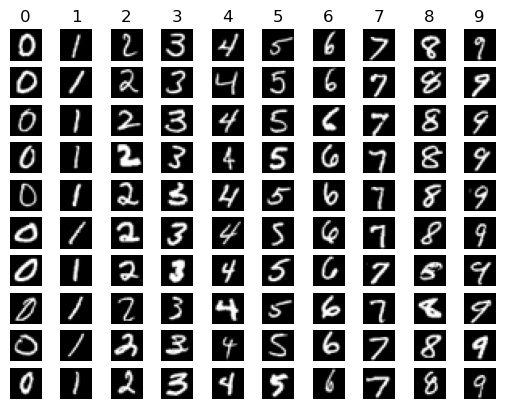

In [7]:
# 5. Visualise examples
printexamples(X, y, mult=255)

In [8]:
# 6. Split into train (60%), validation (20%), test (20%) — use stratify to keep class balance
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

print(f"Training set:   {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set:       {X_test.shape[0]} samples")

Training set:   3000 samples
Validation set: 1000 samples
Test set:       1000 samples


## 2. Linear Support Vector Machine

We begin with a linear SVM. This is often a strong baseline for high-dimensional data.

In [9]:
# 1. Train a linear SVM with default settings
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# 2. Report training and validation accuracy
svm_train_acc = svm_model.score(X_train, y_train)
svm_val_acc = svm_model.score(X_val, y_val)
print(f"Linear SVM Training Accuracy:   {svm_train_acc:.4f}")
print(f"Linear SVM Validation Accuracy: {svm_val_acc:.4f}")
print(f"Gap: {svm_train_acc - svm_val_acc:.4f}")

Linear SVM Training Accuracy:   0.9953
Linear SVM Validation Accuracy: 0.9300
Gap: 0.0653


The training accuracy is very high while the validation accuracy is noticeably lower, with a gap of ~0.065. This indicates some overfitting — the model has memorised patterns in the training data that don't fully generalise to unseen data. However, the validation accuracy is still strong overall. Linear SVMs tend to perform well on high-dimensional data like flattened images (400 features), but the gap suggests the default C=1.0 may be allowing a slightly too-complex decision boundary. Tuning C with cross-validation should help reduce this overfitting.

In [10]:
# 3. Confusion matrix and classification report on validation set
y_val_pred = svm_model.predict(X_val)

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

Confusion Matrix:
[[95  0  2  0  1  1  0  1  0  0]
 [ 0 99  1  0  0  0  0  0  0  0]
 [ 1  7 84  4  1  0  0  1  1  1]
 [ 0  0  0 94  0  3  0  0  2  1]
 [ 0  2  0  0 95  0  1  1  0  1]
 [ 1  0  1  2  0 91  0  0  4  1]
 [ 1  0  1  0  0  1 97  0  0  0]
 [ 1  0  1  0  1  0  0 94  0  3]
 [ 1  2  2  2  0  2  0  0 89  2]
 [ 0  0  1  1  2  0  0  4  0 92]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       100
           1       0.90      0.99      0.94       100
           2       0.90      0.84      0.87       100
           3       0.91      0.94      0.93       100
           4       0.95      0.95      0.95       100
           5       0.93      0.91      0.92       100
           6       0.99      0.97      0.98       100
           7       0.93      0.94      0.94       100
           8       0.93      0.89      0.91       100
           9       0.91      0.92      0.92       100

    accuracy                   

Looking at the confusion matrix, the most frequently confused pair is **2 misclassified as 1** (7 times). Digit 2 has the lowest recall at 0.84, meaning 16% of 2s are being misclassified — it also gets confused with 3 (4 times). Other notable confusions include 8 misclassified as 5 (4 times) and 7 misclassified as 9 (3 times). These make intuitive sense: 2 and 1 can share similar stroke patterns in certain handwriting styles, and 8/5 share curved features. Digit 6 performs best with 0.99 precision and 0.97 recall, likely because its shape is quite distinctive.

In [11]:
# 4. Use 5-fold cross-validation to tune the regularisation parameter C
svm_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

svm_grid = GridSearchCV(SVC(kernel='linear'), svm_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train, y_train)

print(f"Best C: {svm_grid.best_params_['C']}")
print(f"Best CV Accuracy: {svm_grid.best_score_:.4f}")

Best C: 0.1
Best CV Accuracy: 0.9200


In [12]:
# 5. Retrain using the best C on the training set and report validation accuracy
best_svm = SVC(kernel='linear', C=svm_grid.best_params_['C'])
best_svm.fit(X_train, y_train)

svm_best_val_acc = best_svm.score(X_val, y_val)
print(f"Best Linear SVM (C={svm_grid.best_params_['C']}) Validation Accuracy: {svm_best_val_acc:.4f}")

Best Linear SVM (C=0.1) Validation Accuracy: 0.9370


## 3. Random Forest

Now compare to a nonlinear ensemble model.

In [13]:
# 1. Train a RandomForestClassifier with default settings
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

rf_train_acc = rf_model.score(X_train, y_train)
rf_val_acc = rf_model.score(X_val, y_val)
print(f"Random Forest Training Accuracy:   {rf_train_acc:.4f}")
print(f"Random Forest Validation Accuracy: {rf_val_acc:.4f}")
print(f"Gap: {rf_train_acc - rf_val_acc:.4f}")

Random Forest Training Accuracy:   1.0000
Random Forest Validation Accuracy: 0.9430
Gap: 0.0570


**Does this model appear to overfit?**

Yes, the Random Forest achieves 100% training accuracy but only 94.3% validation accuracy, giving a gap of ~0.057. The perfect training score means the model has completely memorised the training data — this is typical behaviour for Random Forests with default settings, where trees are grown to full depth with no constraint. Despite the overfitting, the validation accuracy is actually slightly better than the default linear SVM (94.3% vs 93.0%), suggesting the ensemble approach and nonlinear decision boundaries help capture patterns that a linear model misses.

In [14]:
# 3. Confusion matrix and classification report on validation set
y_val_pred_rf = rf_model.predict(X_val)

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_rf))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_rf))

Confusion Matrix:
[[96  0  1  0  1  0  1  0  1  0]
 [ 0 99  1  0  0  0  0  0  0  0]
 [ 3  2 90  1  0  0  0  3  1  0]
 [ 0  0  1 93  0  3  0  0  2  1]
 [ 0  1  0  0 93  0  1  0  0  5]
 [ 1  1  1  1  0 94  0  0  1  1]
 [ 2  0  0  0  0  1 97  0  0  0]
 [ 0  3  2  0  0  0  0 93  0  2]
 [ 0  0  1  3  0  0  0  0 93  3]
 [ 0  0  0  1  1  0  0  2  1 95]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       100
           1       0.93      0.99      0.96       100
           2       0.93      0.90      0.91       100
           3       0.94      0.93      0.93       100
           4       0.98      0.93      0.95       100
           5       0.96      0.94      0.95       100
           6       0.98      0.97      0.97       100
           7       0.95      0.93      0.94       100
           8       0.94      0.93      0.93       100
           9       0.89      0.95      0.92       100

    accuracy                   

In [15]:
# 4. Use 5-fold cross-validation to tune n_estimators and max_depth
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None]
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)

print(f"Best params: {rf_grid.best_params_}")
print(f"Best CV Accuracy: {rf_grid.best_score_:.4f}")

Best params: {'max_depth': 20, 'n_estimators': 200}
Best CV Accuracy: 0.9280


In [16]:
# 5. Retrain the best model on the training set and report validation accuracy
best_rf = RandomForestClassifier(**rf_grid.best_params_, random_state=42, n_jobs=-1)
best_rf.fit(X_train, y_train)

rf_best_val_acc = best_rf.score(X_val, y_val)
print(f"Best Random Forest Validation Accuracy: {rf_best_val_acc:.4f}")

Best Random Forest Validation Accuracy: 0.9470


## 4. k-Nearest Neighbours

In [17]:
# 1. Train kNN with k=5 and report training and validation accuracy
knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_model.fit(X_train, y_train)

knn_train_acc = knn_model.score(X_train, y_train)
knn_val_acc = knn_model.score(X_val, y_val)
print(f"KNN (k=5) Training Accuracy:   {knn_train_acc:.4f}")
print(f"KNN (k=5) Validation Accuracy: {knn_val_acc:.4f}")
print(f"Gap: {knn_train_acc - knn_val_acc:.4f}")

KNN (k=5) Training Accuracy:   0.9577
KNN (k=5) Validation Accuracy: 0.9340
Gap: 0.0237


**Does this model overfit?**

KNN with k=5 shows a training accuracy of 95.77% and validation accuracy of 93.40%, giving a gap of only ~0.024. This is the smallest gap of any model tested so far, meaning KNN with k=5 generalises the best. This makes sense — with k=5, the model averages over 5 neighbours for each prediction, which acts as a smoothing effect and prevents overfitting to individual training points. Unlike the Random Forest (gap ~0.057) or SVM (gap ~0.065), KNN doesn't try to fit a global decision boundary or build complex trees, so it's less prone to memorising noise.

In [18]:
# 3. Use 5-fold cross-validation to choose the best k
knn_param_grid = {'n_neighbors': list(range(1, 16))}

knn_grid = GridSearchCV(KNeighborsClassifier(n_jobs=-1), knn_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
knn_grid.fit(X_train, y_train)

print(f"Best k: {knn_grid.best_params_['n_neighbors']}")
print(f"Best CV Accuracy: {knn_grid.best_score_:.4f}")

Best k: 1
Best CV Accuracy: 0.9263


In [19]:
# 4. Retrain using the best k and save the validation score
best_knn = KNeighborsClassifier(n_neighbors=knn_grid.best_params_['n_neighbors'], n_jobs=-1)
best_knn.fit(X_train, y_train)

knn_best_val_acc = best_knn.score(X_val, y_val)
print(f"Best KNN (k={knn_grid.best_params_['n_neighbors']}) Validation Accuracy: {knn_best_val_acc:.4f}")

Best KNN (k=1) Validation Accuracy: 0.9370


## 5. Logistic Regression

In [20]:
# 1. Train LogisticRegression with default settings
# 2. Report training and validation accuracy
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

lr_train_acc = lr_model.score(X_train, y_train)
lr_val_acc = lr_model.score(X_val, y_val)
print(f"Logistic Regression Training Accuracy:   {lr_train_acc:.4f}")
print(f"Logistic Regression Validation Accuracy: {lr_val_acc:.4f}")
print(f"Gap: {lr_train_acc - lr_val_acc:.4f}")

Logistic Regression Training Accuracy:   0.9677
Logistic Regression Validation Accuracy: 0.9140
Gap: 0.0537


In [21]:
# 3. Use 5-fold cross-validation to tune regularisation parameter C
lr_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

lr_grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), lr_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
lr_grid.fit(X_train, y_train)

print(f"Best C: {lr_grid.best_params_['C']}")
print(f"Best CV Accuracy: {lr_grid.best_score_:.4f}")

Best C: 1
Best CV Accuracy: 0.8957


In [22]:
# 4. Retrain best model and record validation score
best_lr = LogisticRegression(C=lr_grid.best_params_['C'], max_iter=1000, random_state=42)
best_lr.fit(X_train, y_train)

lr_best_val_acc = best_lr.score(X_val, y_val)
print(f"Best Logistic Regression (C={lr_grid.best_params_['C']}) Validation Accuracy: {lr_best_val_acc:.4f}")

Best Logistic Regression (C=1) Validation Accuracy: 0.9140


## 6. Model Selection

In [23]:
# 1. Compare all tuned model validation scores
print("=== Validation Accuracy Summary ===")
print(f"Linear SVM (C={svm_grid.best_params_['C']}):              {svm_best_val_acc:.4f}")
print(f"Random Forest ({rf_grid.best_params_}): {rf_best_val_acc:.4f}")
print(f"KNN (k={knn_grid.best_params_['n_neighbors']}):                           {knn_best_val_acc:.4f}")
print(f"Logistic Regression (C={lr_grid.best_params_['C']}):      {lr_best_val_acc:.4f}")

# Identify the best model
scores = {
    'Linear SVM': svm_best_val_acc,
    'Random Forest': rf_best_val_acc,
    'KNN': knn_best_val_acc,
    'Logistic Regression': lr_best_val_acc
}
best_model_name = max(scores, key=scores.get)
print(f"\nBest model: {best_model_name} with validation accuracy {scores[best_model_name]:.4f}")

=== Validation Accuracy Summary ===
Linear SVM (C=0.1):              0.9370
Random Forest ({'max_depth': 20, 'n_estimators': 200}): 0.9470
KNN (k=1):                           0.9370
Logistic Regression (C=1):      0.9140

Best model: Random Forest with validation accuracy 0.9470


**Which specific model achieved the best validation performance?**

The best model was a **Random Forest with max_depth=20 and n_estimators=200**, achieving a validation accuracy of 94.70%. This was followed by the Linear SVM (C=0.1) and KNN (k=1), both tied at 93.70%, and Logistic Regression (C=1) at 91.40%. The Random Forest's ability to capture nonlinear relationships through its ensemble of decision trees gives it an edge on this image classification task, where pixel patterns can form complex, non-linear decision boundaries between digit classes.

In [24]:
# 2. Combine training and validation sets
X_combined = np.vstack([X_train, X_val])
y_combined = np.concatenate([y_train, y_val])
print(f"Combined train+val set: {X_combined.shape[0]} samples")

# 3. Retrain the best model on the combined set
# We select the best model dynamically based on validation scores
if best_model_name == 'Linear SVM':
    final_model = SVC(kernel='linear', C=svm_grid.best_params_['C'])
elif best_model_name == 'Random Forest':
    final_model = RandomForestClassifier(**rf_grid.best_params_, random_state=42, n_jobs=-1)
elif best_model_name == 'KNN':
    final_model = KNeighborsClassifier(n_neighbors=knn_grid.best_params_['n_neighbors'], n_jobs=-1)
else:
    final_model = LogisticRegression(C=lr_grid.best_params_['C'], max_iter=1000, random_state=42)

final_model.fit(X_combined, y_combined)
print(f"Retrained {best_model_name} on combined train+val data.")

Combined train+val set: 4000 samples
Retrained Random Forest on combined train+val data.


In [25]:
# 4. Evaluate once on the test set
# 5. Report test accuracy, confusion matrix, and classification report
y_test_pred = final_model.predict(X_test)

test_acc = accuracy_score(y_test, y_test_pred)
print(f"Final Test Accuracy ({best_model_name}): {test_acc:.4f}")
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print(f"\nClassification Report:")
print(classification_report(y_test, y_test_pred))

Final Test Accuracy (Random Forest): 0.9410

Confusion Matrix:
[[99  0  0  0  0  0  0  0  1  0]
 [ 0 99  0  0  1  0  0  0  0  0]
 [ 1  0 97  0  1  0  0  0  1  0]
 [ 0  1  1 89  0  3  0  3  2  1]
 [ 0  0  1  0 95  0  1  1  1  1]
 [ 1  0  0  0  0 93  3  1  1  1]
 [ 1  1  0  0  1  2 93  0  2  0]
 [ 0  1  0  0  2  0  0 94  0  3]
 [ 0  0  1  1  2  1  2  0 90  3]
 [ 1  0  1  2  1  0  0  3  0 92]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       100
           1       0.97      0.99      0.98       100
           2       0.96      0.97      0.97       100
           3       0.97      0.89      0.93       100
           4       0.92      0.95      0.94       100
           5       0.94      0.93      0.93       100
           6       0.94      0.93      0.93       100
           7       0.92      0.94      0.93       100
           8       0.92      0.90      0.91       100
           9       0.91      0.92      0.

## 7. Conclusion

**Which model performed best and why?**

The Random Forest (max_depth=20, n_estimators=200) performed best with a validation accuracy of 94.70% and a final test accuracy of 94.10%. Its strength comes from being a nonlinear ensemble method — it combines hundreds of decision trees, each learning different patterns from random subsets of features and data, then aggregates their predictions through majority voting. This allows it to capture complex, nonlinear relationships between pixel values that linear models (SVM, Logistic Regression) cannot.

**Which model overfit the most?**

The Random Forest with default settings showed the most overfitting, achieving 100% training accuracy but only 94.30% validation accuracy. This is typical for unconstrained trees that grow to full depth and memorise every training sample. The Linear SVM also showed notable overfitting with a gap of ~0.065. Interestingly, KNN with k=5 had the smallest gap (~0.024), as the averaging over neighbours provides natural regularisation.

**Which model was computationally most expensive?**

The Linear SVM with GridSearchCV was by far the most computationally expensive. SVMs scale poorly with sample size (roughly O(n^2) to O(n^3)), and performing 5-fold cross-validation across 6 C values multiplies this. The Random Forest GridSearchCV was also expensive due to the grid over both `n_estimators` and `max_depth` (12 combinations x 5 folds = 60 fits). KNN has negligible training time but slower prediction since it computes distances to all training points at inference.

**Are some models better at distinguishing certain digits?**

Yes. Looking at the final Random Forest test results, digits 0 and 1 were classified most accurately (99% recall each), likely because their shapes are distinctive. Digit 3 had the lowest recall at 89%, being confused with 5 (3 times), 7 (3 times), and 8 (2 times) — all of which share curved stroke elements. Digit 8 also struggled (90% recall), being confused with several digits due to its complex shape containing features similar to many other digits. The SVM showed similar patterns, with digit 2 being its weakest class (84% recall).

**Would you expect a neural network to outperform these models?**

Yes, a Convolutional Neural Network (CNN) would likely outperform all of these classical models. CNNs learn spatial features directly from the 2D image structure (edges, curves, loops) rather than treating each pixel as an independent feature in a flat 400-dimensional vector. This spatial awareness is critical for image classification. On datasets like MNIST (similar to this one), CNNs routinely achieve >99% accuracy, compared to the ~94% we achieved here with our best classical model. The ~5% gap represents the value of learning hierarchical spatial representations versus treating pixel values independently.